**EfficientNet with fine tuning**

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - accuracy: 0.7568 - loss: 0.7298 - val_accuracy: 0.8659 - val_loss: 0.3637
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8577 - loss: 0.4070 - val_accuracy: 0.8661 - val_loss: 0.3495
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.8630 - loss: 0.3808 - val_accuracy: 0.8648 - val_loss: 0.3406
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8691 - loss: 0.3620 - val_accuracy: 0.8702 - val_loss: 0.3310
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8668 - loss: 0.3511 - val_accuracy: 0.8723 - val_loss: 0.3303
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.8716 - loss: 0.3440 - val_accuracy: 0.8773 - val_loss: 0.3301
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.8723 - loss: 0.34

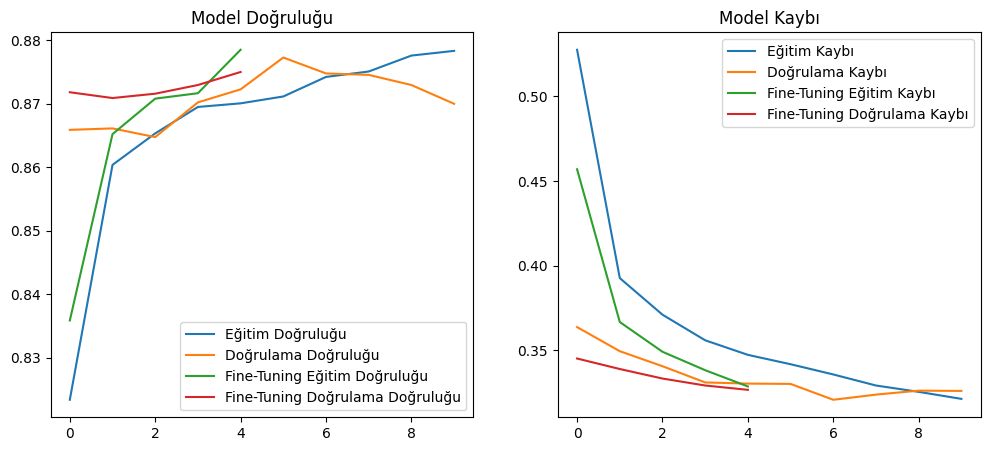

✅ Model başarıyla eğitildi ve kaydedildi!


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri (Kod2'den alındı)
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 10  # İlk eğitim için epoch sayısı
fine_tune_epochs = 90  # Fine-tuning için ek epoch sayısı

# Veri setlerini yükle (Kod2'den alındı)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

# Veri artırma ve normalizasyon (Kod2'den alındı, bu kısımları tekrar eklemiyoruz)
# Veri setlerini performans için optimize et (Kod2'den alındı)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# EfficientNetB0 modelini yükle (transfer öğrenme)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning için bazı katmanları çözme
for layer in base_model.layers[-20:]:  # Son 20 katmanı çöz
    layer.trainable = True

# Modeli yeniden derle (daha düşük öğrenme oranı ile)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning için modeli yeniden eğit
history_fine = model.fit(
    train_dataset,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Eğitim Doğruluğu')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Eğitim Kaybı')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('efficientnetb0_fine_tuned_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

**EfficientNet with fine tuning and Attention**

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 55s 128ms/step - accuracy: 0.7518 - loss: 0.7673 - val_accuracy: 0.8684 - val_loss: 0.3575
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.8623 - loss: 0.3774 - val_accuracy: 0.8709 - val_loss: 0.3450
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8691 - loss: 0.3599 - val_accuracy: 0.8704 - val_loss: 0.3345
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.8686 - loss: 0.3430 - val_accuracy: 0.8755 - val_loss: 0.3289
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8706 - loss: 0.3382 - val_accuracy: 0.8734 - val_loss: 0.3298
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.8743 - loss: 0.3272 - val_accuracy: 0.8686 - val_loss: 0.3274
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.8790 - loss: 0.3158 - val_accuracy: 0.8770 - val_loss: 0.3214
Epoch 

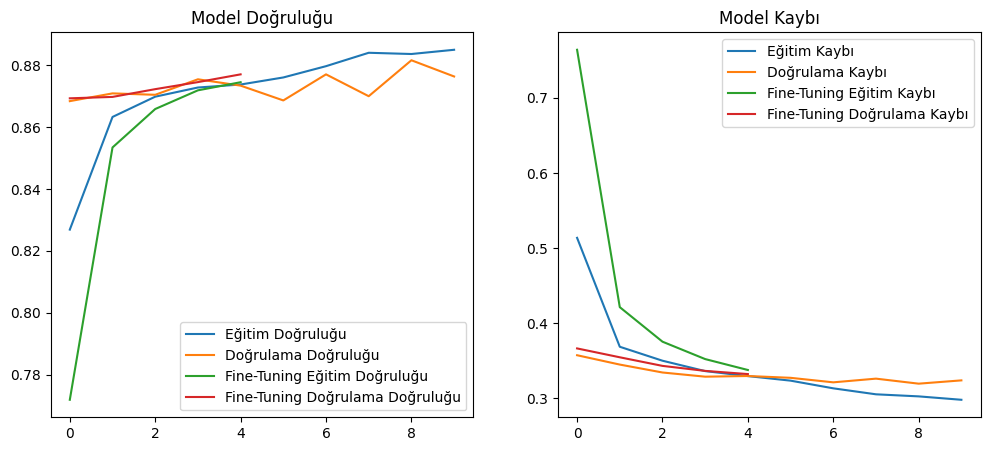

✅ Model başarıyla eğitildi ve kaydedildi!


In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Multiply, Add, Conv2D, Reshape, Permute, Activation, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 10  # İlk eğitim için epoch sayısı
fine_tune_epochs = 90  # Fine-tuning için ek epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

# Veri artırma ve normalizasyon (Kod2'den alındı, bu kısımları tekrar eklemiyoruz)
# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Channel Attention Katmanı
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = Dense(channel // self.ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=False)
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        # Add and Sigmoid
        channel_attention = Add()([avg_pool, max_pool])
        channel_attention = Activation('sigmoid')(channel_attention)

        return Multiply()([inputs, channel_attention])

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({'ratio': self.ratio})
        return config

# Spatial Attention Katmanı
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv(concat)
        return Multiply()([inputs, spatial_attention])

    def get_config(self):
        return super(SpatialAttention, self).get_config()

# EfficientNetB0 modelini yükle (transfer öğrenme)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Attention mekanizmalarını ekleyerek modeli oluştur
inputs = base_model.input
x = base_model.output

# Channel Attention
x = ChannelAttention()(x)

# Spatial Attention
x = SpatialAttention()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning için bazı katmanları çözme
for layer in base_model.layers[-20:]:  # Son 20 katmanı çöz
    layer.trainable = True

# Modeli yeniden derle (daha düşük öğrenme oranı ile)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning için modeli yeniden eğit
history_fine = model.fit(
    train_dataset,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Eğitim Doğruluğu')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Eğitim Kaybı')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('efficientnetb0_attention_fine_tuned_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

**Eğitimde kullanılan veri setinden doğru tahmin**

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: N
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/N/2956_left.jpg


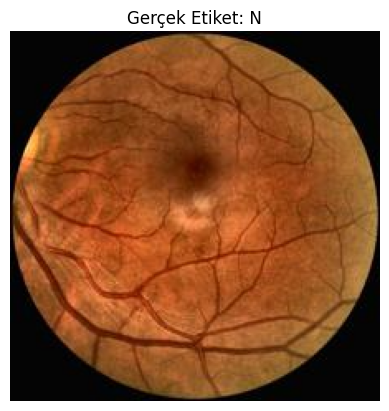

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Gerçek Etiket: N
Tahmin Edilen Etiket: N
Tahmin Olasılıkları: [0.00582173 0.00221396 0.30095637 0.00934069 0.00121135 0.00103089
 0.66945726 0.00996775]


In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

**Eğitimde kullanılan veri setinden yanlış tahmin**

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: A
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/A/230_left.jpg


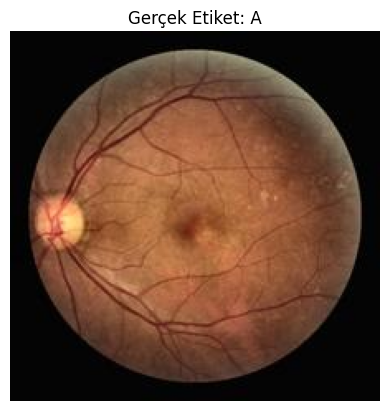

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Gerçek Etiket: A
Tahmin Edilen Etiket: N
Tahmin Olasılıkları: [0.06043253 0.0024455  0.31410614 0.01391171 0.026395   0.00215315
 0.50067085 0.07988515]


In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

**Farklı veri setiyle test**

Doğru tahmin

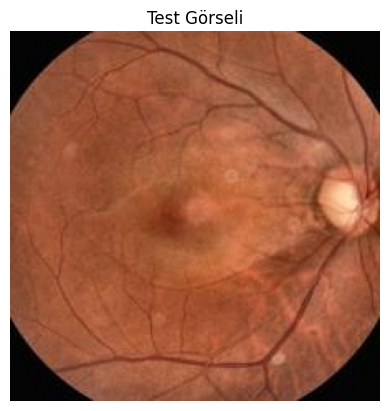

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Rastgele Seçilen Görsel: 1469_right.jpg
Gerçek Sınıf: G
Tahmin Edilen Sınıf: G
Tahmin Olasılıkları: [0.04865332 0.00397766 0.06318266 0.4346566  0.00593086 0.00138142
 0.29999122 0.14222626]


In [21]:
import numpy as np
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test verisinin bulunduğu klasör
test_dir = "/kaggle/input/eski-veri-seti-snf-karm"  # Buraya test verisinin olduğu ana klasörü yazın

# Test klasörleri (sınıflar)
class_names = os.listdir(test_dir)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
class_path = os.path.join(test_dir, random_class)

# Seçilen sınıftan rastgele bir görsel seç
image_name = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Görseli yükle ve 224x224 boyutuna getir
img = image.load_img(image_path, target_size=(224, 224))

# Görseli numpy array'e dönüştür
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)

# Normalizasyon işlemi (EfficientNet için gerekli)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Görseli ekranda göster
plt.imshow(img)
plt.axis("off")
plt.title("Test Görseli")
plt.show()

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Tahmin edilen sınıf ismi
predicted_class_name = class_names[predicted_class_index]

# Tahmin sonucunu yazdır
print(f"Rastgele Seçilen Görsel: {image_name}")
print(f"Gerçek Sınıf: {random_class}")
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

Yanlış tahmin

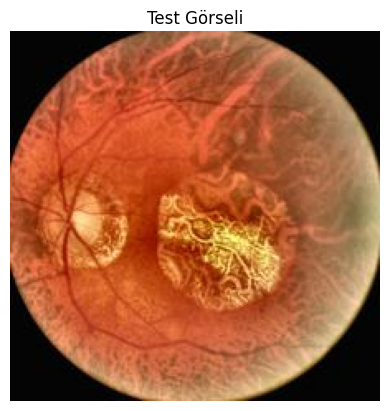

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Rastgele Seçilen Görsel: 1065_left.jpg
Gerçek Sınıf: A
Tahmin Edilen Sınıf: N
Tahmin Olasılıkları: [5.5630678e-01 1.1931188e-02 8.9905627e-02 4.9361354e-04 4.5261241e-04
 9.8425694e-02 2.3420727e-01 8.2772151e-03]


In [22]:
import numpy as np
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test verisinin bulunduğu klasör
test_dir = "/kaggle/input/eski-veri-seti-snf-karm"  # Buraya test verisinin olduğu ana klasörü yazın

# Test klasörleri (sınıflar)
class_names = os.listdir(test_dir)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
class_path = os.path.join(test_dir, random_class)

# Seçilen sınıftan rastgele bir görsel seç
image_name = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Görseli yükle ve 224x224 boyutuna getir
img = image.load_img(image_path, target_size=(224, 224))

# Görseli numpy array'e dönüştür
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)

# Normalizasyon işlemi (EfficientNet için gerekli)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Görseli ekranda göster
plt.imshow(img)
plt.axis("off")
plt.title("Test Görseli")
plt.show()

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Tahmin edilen sınıf ismi
predicted_class_name = class_names[predicted_class_index]

# Tahmin sonucunu yazdır
print(f"Rastgele Seçilen Görsel: {image_name}")
print(f"Gerçek Sınıf: {random_class}")
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")
print(f"Tahmin Olasılıkları: {predictions[0]}")